## Cross Matching the Debris Disks with Andrae 2023

https://arxiv.org/pdf/2302.02611
https://zenodo.org/records/7945154

In [ ]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
Gaia.login(user='jadams02', password='LkCa15bcde!')

INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]


## Crossmatch function for GAIA first

In [3]:
def gaia_match_one(ra_deg, dec_deg, radius_arcsec=1.0):
    coord = SkyCoord(ra_deg*u.deg, dec_deg*u.deg, frame="icrs")
    job = Gaia.cone_search_async(coord, radius=radius_arcsec*u.arcsec)
    t = job.get_results()
    if len(t) == 0:
        return None
    t.sort("dist")
    return int(t["source_id"][0])

In [5]:
alma_unique = pd.read_csv("alma_debris_disks_unique_targets.csv")

alma_unique.head()

,s_ra,s_dec,target_name,band_list,t_exptime
0,77.114167,-21.025000,1RXS_J050827.3-210130,7,846.720
1,262.336160,-50.248335,1RXS_J172919.1-501454,7,967.680
2,211.949501,-39.762023,1swasp_j140747.93-394542.6,7,9215.937
3,79.972042,6.290336,2MASS_J05195327+0617258,7,967.680
4,81.079754,-16.020917,2MASS_J05241914-1601153,7,876.960


## Gaia cross match code
Comment out when not using, because it takes 20 minutes to run

In [ ]:
# alma_unique["gaia_source_id"] = [
#     gaia_match_one(ra, dec)
#     for ra, dec in zip(alma_unique["s_ra"], alma_unique["s_dec"])
# ]

# print(f"{alma_unique['gaia_source_id'].notna().sum()} / {len(alma_unique)} matched")

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [8]:
# Save output table
alma = alma_unique.copy()

alma.to_csv(
    "alma_debris_disks_unique_with_gaiaDR3.csv",
    index=False
)

In [11]:
alma = alma_unique.copy()  

# Keep only matched rows for the Gaia query
m = alma.dropna(subset=["gaia_source_id"]).copy()
m["gaia_source_id"] = m["gaia_source_id"].astype("int64")

# Query Gaia positions for those source_ids (chunked to avoid long IN() lists)
def fetch_gaia_positions(source_ids, chunk=15000):
    out = []
    for i in range(0, len(source_ids), chunk):
        ids = source_ids[i:i+chunk]
        id_list = ",".join(map(str, ids))
        q = f"""
        SELECT source_id, ra, dec
        FROM gaiadr3.gaia_source
        WHERE source_id IN ({id_list})
        """
        job = Gaia.launch_job_async(q)
        out.append(job.get_results().to_pandas())
    return pd.concat(out, ignore_index=True)

gaia_pos = fetch_gaia_positions(m["gaia_source_id"].tolist())

# Merge and compute sep_arcsec
mm = m.merge(gaia_pos, left_on="gaia_source_id", right_on="source_id", how="left")

c_alma = SkyCoord(mm["s_ra"].values*u.deg, mm["s_dec"].values*u.deg, frame="icrs")
c_gaia = SkyCoord(mm["ra"].values*u.deg,  mm["dec"].values*u.deg,  frame="icrs")

mm["sep_arcsec"] = c_alma.separation(c_gaia).arcsec

# Put sep_arcsec back onto the master table
alma = alma.merge(mm[["target_name", "gaia_source_id", "sep_arcsec"]], on=["target_name","gaia_source_id"], how="left")

alma.to_csv("alma_debris_unique_with_gaiaDR3_and_sep.csv", index=False)
print("Saved alma_debris_unique_with_gaiaDR3_and_sep.csv")
print(mm["sep_arcsec"].describe())

INFO: Query finished. [astroquery.utils.tap.core]
Saved alma_debris_unique_with_gaiaDR3_and_sep.csv
count    178.000000
mean       2.271069
std        9.137135
min        0.015073
25%        0.170451
50%        0.232197
75%        0.591471
max       63.302809
Name: sep_arcsec, dtype: float64


## Adding a quality check 

	•	< 1.0″ = “good” 
	•	1–5″ = “questionable”
	•	> 5″ = “likely wrong / needs manual check”


In [15]:
alma["gaia_match_quality"] = "good"
alma.loc[alma["sep_arcsec"] > 1.0, "gaia_match_quality"] = "questionable"
alma.loc[alma["sep_arcsec"] > 5.0, "gaia_match_quality"] = "bad"

In [13]:
alma_clean = alma[alma["sep_arcsec"] < 1.0].copy()

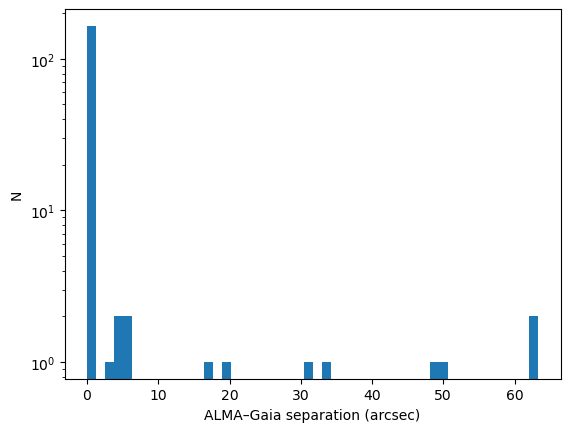

In [ ]:
plt.hist(alma["sep_arcsec"], bins=50)
plt.yscale("log")
plt.xlabel("ALMA–Gaia separation (arcsec)")
plt.ylabel("N")
plt.show()

In [16]:
# Also useful to keep an explicit boolean
alma["has_gaia"] = alma["gaia_source_id"].notna()

alma.to_csv(
    "alma_debris_unique_with_gaiaDR3_sep_quality.csv",
    index=False
)

print("Saved alma_debris_unique_with_gaiaDR3_sep_quality.csv")
alma["gaia_match_quality"].value_counts()

Saved alma_debris_unique_with_gaiaDR3_sep_quality.csv


gaia_match_quality
good            764
bad              10
questionable      5
Name: count, dtype: int64